In [1]:
import shap
import cv2
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import copy
%matplotlib inline
import skimage.segmentation
from sklearn.linear_model import LinearRegression
from skimage.color import gray2rgb
import os
from PIL import Image
import joblib

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage.color import rgb2gray
import matplotlib.pylab as plt

In [3]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import ipyplot

input_img = imageio.imread('proj/xai_thyroid/Data/datapre/108_1.jpg')
rot1 = iaa.Affine(rotate=(-90))
input_rot1 = rot1.augment_image(input_img)
# images_list=[input_img, input_rot1]
# labels = ['Original', 'Rotated Image']
# ipyplot.plot_images(images_list,labels=labels,img_width=180)

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


In [4]:

# read by default 1st sheet of an excel file
# df = pd.read_excel('xai_thyroid/Data/labels.xlsx', header=0)
# df.to_csv('xai_thyroid/Data/labels.csv', index=False)
dataframe = pd.read_csv("proj/xai_thyroid/Data/labels.csv", encoding='utf-8')
dataframe = dataframe[:480]
# print(dataframe)

dataset = []
for i in range(len(dataframe)):
    if dataframe["Cla1"][i]==0:
        continue
    row_data = []
    
    for row in dataframe:
        row_data.append(dataframe[row][i])
    dataset.append(row_data)

dataset

[['2_1', 1, '2'],
 ['3_1', 2, '4a'],
 ['4_1', 2, '4a'],
 ['5_1', 2, '5'],
 ['6_1', 2, '4b'],
 ['7_1', 2, '4a'],
 ['8_1', 2, '4c'],
 ['9_1', 2, '4b'],
 ['10_1', 2, '4b'],
 ['11_1', 2, '5'],
 ['12_1', 2, '4a'],
 ['13_1', 2, '4a'],
 ['14_1', 1, '2'],
 ['15_1', 2, '4c'],
 ['16_1', 1, '3'],
 ['17_1', 1, '2'],
 ['18_1', 2, '4a'],
 ['19_1', 2, '5'],
 ['20_1', 2, '4b'],
 ['21_1', 2, '4a'],
 ['22_1', 1, '2'],
 ['23_1', 2, '4a'],
 ['24_1', 2, '4b'],
 ['25_1', 1, '3'],
 ['26_1', 2, '4a'],
 ['27_1', 2, '4b'],
 ['28_1', 2, '4b'],
 ['29_1', 2, '5'],
 ['30_1', 2, '4c'],
 ['31_1', 1, '3'],
 ['32_1', 2, '4a'],
 ['33_1', 2, '4a'],
 ['34_1', 2, '4c'],
 ['35_1', 2, '4b'],
 ['36_1', 2, '5'],
 ['38_1', 2, '4b'],
 ['39_1', 2, '4a'],
 ['40_1', 2, '4a'],
 ['41_1', 2, '4b'],
 ['42_1', 2, '4b'],
 ['43_1', 2, '4c'],
 ['44_1', 2, '4a'],
 ['45_1', 2, '4b'],
 ['46_1', 2, '5'],
 ['47_1', 2, '4a'],
 ['48_1', 2, '4b'],
 ['49_1', 2, '4a'],
 ['50_1', 2, '4a'],
 ['51_1', 1, '2'],
 ['52_1', 2, '4a'],
 ['53_1', 2, '4c'],
 [

In [5]:
import cv2
import numpy as np
from scipy.fftpack import dct

def pb_dct(image, block_size=8, threshold=0.5):
    # Ensure the image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Pad the image to a multiple of the block size
    height, width = image.shape
    pad_height = ((height + block_size - 1) // block_size) * block_size
    pad_width = ((width + block_size - 1) // block_size) * block_size
    padded_image = np.zeros((pad_height, pad_width))
    padded_image[:height, :width] = image
    
    # Initialize the PB-DCT coefficients matrix
    pb_dct_coeffs = np.zeros((pad_height, pad_width))
    
    # Perform PB-DCT on blocks
    for y in range(0, pad_height, block_size):
        for x in range(0, pad_width, block_size):
            block = padded_image[y:y+block_size, x:x+block_size]
            dct_block = dct(dct(block, axis=0, norm='ortho'), axis=1, norm='ortho')
            
            # Apply polar binarization to the DCT coefficients
            pb_dct_block = polar_binarization(dct_block, threshold)
            
            pb_dct_coeffs[y:y+block_size, x:x+block_size] = pb_dct_block
    
    return pb_dct_coeffs

def polar_binarization(block, threshold=0.5):
    # Calculate the polar angle
    angle = np.arctan2(block, block[::-1])
    
    # Binarize based on the threshold
    binarized_block = np.where(np.abs(angle) >= threshold, 1, 0)
    
    return binarized_block

path = 'proj/xai_thyroid/Data/datapre/' + "3_1" + '.jpg'
image = imread(path)
block_size = 8
threshold = 0.5
pb_dct_coeffs = pb_dct(image, block_size, threshold)
print(pb_dct_coeffs)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 1. 1.]
 [0. 1. 1. ... 0. 1. 1.]]


In [6]:
import os
import time
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.fftpack import dct

def features_of_single_image(I):
    block_size = 8
    threshold = 0.5
    pb_dct_coeffs = pb_dct(I, block_size, threshold)
    flattened = pb_dct_coeffs.ravel()  
    return flattened

path = 'proj/xai_thyroid/Data/datapre/' + "108_1" + '.jpg'
img = imread(path)
img=gray2rgb(img)
print(img.shape)
print(len(features_of_single_image(img)))

(300, 300, 3)
92416


In [7]:
path = 'proj/xai_thyroid/Data/datapre/' + "108_1" + '.jpg'
img = imread(path)
img=gray2rgb(img)
print(img)
features_of_single_image(img)

[[[  0   0   0]
  [ 10  10  10]
  [189 189 189]
  ...
  [  2   2   2]
  [  1   1   1]
  [  0   0   0]]

 [[  0   0   0]
  [115 115 115]
  [253 253 253]
  ...
  [  3   3   3]
  [ 10  10  10]
  [ 12  12  12]]

 [[ 62  62  62]
  [255 255 255]
  [255 255 255]
  ...
  [119 119 119]
  [108 108 108]
  [155 155 155]]

 ...

 [[  6   6   6]
  [  8   8   8]
  [ 55  55  55]
  ...
  [110 110 110]
  [125 125 125]
  [144 144 144]]

 [[  0   0   0]
  [  0   0   0]
  [ 47  47  47]
  ...
  [ 87  87  87]
  [ 97  97  97]
  [109 109 109]]

 [[  9   9   9]
  [  6   6   6]
  [ 59  59  59]
  ...
  [116 116 116]
  [106 106 106]
  [105 105 105]]]


array([1., 1., 1., ..., 0., 0., 1.])

In [8]:
path = 'proj/xai_thyroid/Data/datapre/' + "3_1" + '.jpg'
img = imread(path)
img=gray2rgb(img)
print(img)
features_of_single_image(img)

[[[ 74  74  74]
  [139 139 139]
  [ 10  10  10]
  ...
  [  0   0   0]
  [  0   0   0]
  [  3   3   3]]

 [[219 219 219]
  [242 242 242]
  [133 133 133]
  ...
  [115 115 115]
  [106 106 106]
  [ 95  95  95]]

 [[255 255 255]
  [255 255 255]
  [238 238 238]
  ...
  [203 203 203]
  [199 199 199]
  [183 183 183]]

 ...

 [[ 30  30  30]
  [171 171 171]
  [174 174 174]
  ...
  [ 62  62  62]
  [ 51  51  51]
  [ 39  39  39]]

 [[ 29  29  29]
  [147 147 147]
  [154 154 154]
  ...
  [ 22  22  22]
  [ 15  15  15]
  [  8   8   8]]

 [[  0   0   0]
  [ 75  75  75]
  [ 71  71  71]
  ...
  [ 39  39  39]
  [ 32  32  32]
  [ 24  24  24]]]


array([1., 1., 1., ..., 0., 1., 1.])

In [9]:
X = []
Y = []
count = 0
for row in dataset:
    path = 'proj/xai_thyroid/Data/datapre/' + row[0] + '.jpg'
    img = imread(path)
    img=gray2rgb(img)
    X.append(features_of_single_image(img))
    Y.append(row[1])
        
    count=count+1
    print(count)
    
print(len(X))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [10]:
X[0]

array([1., 1., 1., ..., 1., 1., 1.])

In [11]:
from imblearn.over_sampling import SMOTE
smt=SMOTE()
X_n,Y_n=smt.fit_resample(X,Y)

In [12]:
print(len(X_n))
print(len(Y_n))
X=X_n
Y=Y_n

576
576


In [13]:
x1=x2=0
for x in Y_n:
    if(x==1):
        x1=x1+1
    if(x==2):
        x2=x2+1
print(x1," ",x2)

288   288


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,
                                   random_state=104, 
                                   test_size=0.2, 
                                   shuffle=True)
print(len(X_train))
print(len(X_test))

460
116


In [15]:
# import support vector classifier 
# "Support Vector Classifier"
from sklearn.svm import SVC  
clf = SVC(kernel='linear', probability=True) 
  
# fitting x samples and y classes 
clf.fit(X_train,Y_train) 

SVC(kernel='linear', probability=True)

In [16]:
count =0
for i in range(len(X_test)):
    ans=clf.predict([X_test[i]])
    if(ans[0]!=Y_test[i]):
        print(i, " ", ans[0], " ", Y_test[i])
        count += 1
count

75   2   1


1

In [17]:
print(len(X[0]))

92416


# custom lime code

In [19]:
"""
Implementation of Local interpretable model-agnostic explanations.
Source: Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin.
"Why should I trust you?: Explaining the predictions of any classifier."
Proceedings of the 22nd ACM SIGKDD international conference on knowledge
discovery and data mining. ACM (2016).
"""
import tensorflow as tf
import numpy as np
from typing import Tuple
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import skimage
import matplotlib.pyplot as plt

EXPLAINABLE_MODELS = {
    'linear_regression': LinearRegression,
    'decision_tree_regressor': DecisionTreeRegressor
}


class LIME:

    def __init__(self, image: tf.Tensor, model: tf.keras.Model, random_seed: int = 9):
        """
        Parameters
        ----------
        image: tf.Tensor; Image for which the explanation should be made
        model: tf.keras.Model; Base model
        """
        self.image = image
        self.model = model
        self.random_seed = random_seed
        self.super_pixels, self.super_pixel_count = self.create_super_pixels()
        self.perturbation_vectors = self.generate_pertubation_vectors()

    def create_super_pixels(
            self, kernel_size: int = 8, max_dist: int = 1000, ratio: float = 0.2
    ) -> Tuple[np.ndarray, int]:
        """
        Parameters
        ----------
        kernel_size, max_dist, ratio: parameters for skimage.segmentation.quickshift function.
        See https://scikit-image.org/docs/stable/api/skimage.segmentation.html for more info

        Returns
        -------
        super_pixels: np.ndarray (shape==self.image.shape); Contains
        integers to which super pixel area the location belongs
        super_pixel_count: int; total number of different superpixel areas
        """
        super_pixels = skimage.segmentation.quickshift(
            self.image, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio
        )
        super_pixel_count = len(np.unique(super_pixels))
        return super_pixels, super_pixel_count

    def plot_super_pixel_boundary(self):
        """ Plots the boundaries of the superpixel areas """
        super_pixel_boundaries = skimage.segmentation.mark_boundaries(
            self.image, self.super_pixels
        )
        plt.imshow(super_pixel_boundaries)
        plt.title('Superpixel boundaries')

    def generate_pertubation_vectors(self, num_perturbations: int = 1000) -> np.ndarray:
        """
        Generates a number of perturbation vectors. These are binary vectors of length
        num_super_pixels, which define if a superpixel is perturbed

        Parameters
        ----------
        num_perturbations: int; total number of perturbations

        Returns
        -------
        np.ndarray (shape=(num_perturbations, super_pixel_count); binary array defining if a
        superpixel area should be perturbed
        """
        if self.random_seed is not None:
            np.random.seed(self.random_seed)
        return np.random.binomial(1, 0.5, size=(num_perturbations, self.super_pixel_count))

    def predict_perturbed_images(self) -> np.ndarray:
        """
        Generates predictions for all perturbed_images

        Returns
        -------
        np.ndarray (shape=(num_perturbations, num_output_classes)); contains predictions for all
        perturbed images
        """
        perturbed_images = self.create_perturbed_images()
        ans = []
        for img in perturbed_images:
            ans.append(clf.predict([features_of_single_image(img)]))
        ans = np.array(ans)
        return ans

    def create_perturbed_images(self) -> np.ndarray:
        """ Creates perturbed images based on all pertubation vectors """
        self.generate_pertubation_vectors()
        return np.apply_along_axis(
            lambda x: self._create_perturbed_image(x), 1, self.perturbation_vectors
        )

    def _create_perturbed_image(self, perturbation_vector: np.ndarray) -> np.ndarray:
        """
        Creatas a single perturbed image

        Parameters
        ----------
        perturbation_vector; np.ndarray (shape=(num_perturbations, super_pixel_count); binary array
        defining if a superpixel area should be perturbed

        Returns
        -------
        np.ndarray (shape==self.image.shape); contains original image info or perturbed image
        dependent on the perturbation_vector
        """
        perturbation_mask = np.isin(self.super_pixels, np.argwhere(perturbation_vector == 1))
        return np.where(np.expand_dims(perturbation_mask, -1), self.image, 0)

    def plot_perturbed_image(self):
        """ Plots a single perturbed image """
        if self.perturbation_vectors is None:
            self.generate_pertubation_vectors()

        if self.random_seed is not None:
            np.random.seed(self.random_seed)
        idx = np.random.randint(len(self.perturbation_vectors))
        perturbed_img = self._create_perturbed_image(self.perturbation_vectors[idx])

        plt.imshow(perturbed_img.astype(int))
        plt.title('Perturbed Image')

    def calculate_perturbation_weights(self, kernel_width: float = 0.25) -> np.ndarray:
        """
        Calculates the perturbation weights. First the distance between the perturbed images
        and the original image is calculated. A kernel function is used to map these distances
        to weights. The smaller the distance to the original image, the larger the weight. The
        intuition behind this is that if a perturbed image is very close to the original image,
        (let's say only 1 perturbed superpixel area), there is a lot of information in this
        sample, as it tells a lot on the 1 perturbed superpixel area importance.

        Parameters
        ----------
        kernel_width: float; defines the width of the kernel that is used

        Returns
        -------
        np.ndarray (shape=(num_perturbations,)); weights for each perturbation
        """
        non_perturbed_vector = np.ones((1, self.super_pixel_count))
        distances = pairwise_distances(
            self.perturbation_vectors, non_perturbed_vector, metric='cosine'
        )
        return np.squeeze(np.sqrt(np.exp(-(distances ** 2) / kernel_width ** 2)))

    def _fit_explainable_model(
            self,
            predictions: np.ndarray,
            weights: np.ndarray,
            explainable_model_type: str = 'decision_tree_regressor'
    ) -> np.ndarray:
        """
        Function to fit an exmplainable model and define the importance of each superpixel area

        Parameters
        ----------
        predictions: np.ndarray (shape=(num_perturbations, num_output_classes)); contains
        predictions for all perturbed images
        weights: np.ndarray (shape=(num_perturbations,)); weights for each perturbation
        explainable_model_type: str containing the type of explainable model

        Returns
        -------
        feature_importances: np.ndarray (shape=(super_pixel_count,)); importance of each superpixel
        for predicting a specific class
        """
        if explainable_model_type not in EXPLAINABLE_MODELS.keys():
            raise ValueError(
                f"Please specify one of the following model_types: {EXPLAINABLE_MODELS.keys()}"
            )

        model = EXPLAINABLE_MODELS[explainable_model_type]()
        model.fit(X=self.perturbation_vectors, y=predictions, sample_weight=weights)
        if 'regression' in explainable_model_type:
            feature_importance = model.coef_
        elif 'tree' in explainable_model_type:
            feature_importance = model.feature_importances_
        else:
            raise ValueError(
                f"Please specify one of the following model_types: {EXPLAINABLE_MODELS.keys()}"
            )

        return feature_importance

    def plot_explainable_image(self, class_to_explain: int = None, num_superpixels: int = 4,
                               explainable_model_type: str = 'decision_tree_regressor'):
        """
        Plots the most important super pixel areas for predicting a specific class

        Parameters
        ----------
        class_to_explain: int; which class to plot the explanations for. If not specified, will
        default to the class with the highest probability
        num_superpixels: int; defines how many superpixel areas will be plotted
        explainable_model_type: str; which explainable model to use to generate explainability plot
        """
        # get perturbed image predictions & weights
        # print(type(self))
        perturbed_image_predictions = self.predict_perturbed_images()
        weights = self.calculate_perturbation_weights()
        if class_to_explain is None:
            # print(self.image.shape)
            class_to_explain = []
            class_to_explain = (clf.predict([features_of_single_image(self.image)]))
            class_to_explain = np.array(class_to_explain)
            class_to_explain = np.argmax(class_to_explain)
            
        # fit simple interpretable model
        feature_importance = self._fit_explainable_model(
            predictions=perturbed_image_predictions[:, class_to_explain],
            weights=weights,
            explainable_model_type=explainable_model_type
        )
        # Define which superpixel areas should be plotted
        superpixels_to_plot = np.argsort(feature_importance)[-num_superpixels:]
        superpixel_vector = np.zeros(self.super_pixel_count)
        np.put(superpixel_vector, superpixels_to_plot, v=1)
        
        # Create the image
        perturbed_img = self._create_perturbed_image(superpixel_vector)
        plt.imshow(perturbed_img.astype(int))
        plt.title('LIME explanation')

In [20]:
import PIL
import tensorflow as tf

In [1]:
cnt=0
for i in os.listdir('C:/Users/PRATHMESH/OneDrive/Desktop/BTP material/proj/xai_thyroid/Data/datapre/'):
    if i=='.ipynb_checkpoints':
        continue
    img = PIL.Image.open('C:/Users/PRATHMESH/OneDrive/Desktop/BTP material/proj/xai_thyroid/Data/datapre/'+i)
    img=np.stack((img,)*3, axis=-1)
    img=np.array(img)
    EXPLAINABLE_MODELS = {
    'linear_regression': LinearRegression,
    'decision_tree_regressor': DecisionTreeRegressor
    }
    
    
    class LIME:
    
        def __init__(self, image: tf.Tensor, model: tf.keras.Model, random_seed: int = 9):
            """
            Parameters
            ----------
            image: tf.Tensor; Image for which the explanation should be made
            model: tf.keras.Model; Base model
            """
            self.image = image
            self.model = model
            self.random_seed = random_seed
            self.super_pixels, self.super_pixel_count = self.create_super_pixels()
            self.perturbation_vectors = self.generate_pertubation_vectors()
    
        def create_super_pixels(
                self, kernel_size: int = 8, max_dist: int = 1000, ratio: float = 0.2
        ) -> Tuple[np.ndarray, int]:
            """
            Parameters
            ----------
            kernel_size, max_dist, ratio: parameters for skimage.segmentation.quickshift function.
            See https://scikit-image.org/docs/stable/api/skimage.segmentation.html for more info
    
            Returns
            -------
            super_pixels: np.ndarray (shape==self.image.shape); Contains
            integers to which super pixel area the location belongs
            super_pixel_count: int; total number of different superpixel areas
            """
            super_pixels = skimage.segmentation.quickshift(
                self.image, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio
            )
            super_pixel_count = len(np.unique(super_pixels))
            return super_pixels, super_pixel_count
    
        def plot_super_pixel_boundary(self):
            """ Plots the boundaries of the superpixel areas """
            super_pixel_boundaries = skimage.segmentation.mark_boundaries(
                self.image, self.super_pixels
            )
            plt.imshow(super_pixel_boundaries)
            plt.title('Superpixel boundaries')
    
        def generate_pertubation_vectors(self, num_perturbations: int = 1000) -> np.ndarray:
            """
            Generates a number of perturbation vectors. These are binary vectors of length
            num_super_pixels, which define if a superpixel is perturbed
    
            Parameters
            ----------
            num_perturbations: int; total number of perturbations
    
            Returns
            -------
            np.ndarray (shape=(num_perturbations, super_pixel_count); binary array defining if a
            superpixel area should be perturbed
            """
            if self.random_seed is not None:
                np.random.seed(self.random_seed)
            return np.random.binomial(1, 0.5, size=(num_perturbations, self.super_pixel_count))
    
        def predict_perturbed_images(self) -> np.ndarray:
            """
            Generates predictions for all perturbed_images
    
            Returns
            -------
            np.ndarray (shape=(num_perturbations, num_output_classes)); contains predictions for all
            perturbed images
            """
            perturbed_images = self.create_perturbed_images()
            ans = []
            for img in perturbed_images:
                ans.append(clf.predict([features_of_single_image(img)]))
            ans = np.array(ans)
            return ans
    
        def create_perturbed_images(self) -> np.ndarray:
            """ Creates perturbed images based on all pertubation vectors """
            self.generate_pertubation_vectors()
            return np.apply_along_axis(
                lambda x: self._create_perturbed_image(x), 1, self.perturbation_vectors
            )
    
        def _create_perturbed_image(self, perturbation_vector: np.ndarray) -> np.ndarray:
            """
            Creatas a single perturbed image
    
            Parameters
            ----------
            perturbation_vector; np.ndarray (shape=(num_perturbations, super_pixel_count); binary array
            defining if a superpixel area should be perturbed
    
            Returns
            -------
            np.ndarray (shape==self.image.shape); contains original image info or perturbed image
            dependent on the perturbation_vector
            """
            perturbation_mask = np.isin(self.super_pixels, np.argwhere(perturbation_vector == 1))
            return np.where(np.expand_dims(perturbation_mask, -1), self.image, 0)
    
        def plot_perturbed_image(self):
            """ Plots a single perturbed image """
            if self.perturbation_vectors is None:
                self.generate_pertubation_vectors()
    
            if self.random_seed is not None:
                np.random.seed(self.random_seed)
            idx = np.random.randint(len(self.perturbation_vectors))
            perturbed_img = self._create_perturbed_image(self.perturbation_vectors[idx])
    
            plt.imshow(perturbed_img.astype(int))
            plt.title('Perturbed Image')
    
        def calculate_perturbation_weights(self, kernel_width: float = 0.25) -> np.ndarray:
            """
            Calculates the perturbation weights. First the distance between the perturbed images
            and the original image is calculated. A kernel function is used to map these distances
            to weights. The smaller the distance to the original image, the larger the weight. The
            intuition behind this is that if a perturbed image is very close to the original image,
            (let's say only 1 perturbed superpixel area), there is a lot of information in this
            sample, as it tells a lot on the 1 perturbed superpixel area importance.
    
            Parameters
            ----------
            kernel_width: float; defines the width of the kernel that is used
    
            Returns
            -------
            np.ndarray (shape=(num_perturbations,)); weights for each perturbation
            """
            non_perturbed_vector = np.ones((1, self.super_pixel_count))
            distances = pairwise_distances(
                self.perturbation_vectors, non_perturbed_vector, metric='cosine'
            )
            return np.squeeze(np.sqrt(np.exp(-(distances ** 2) / kernel_width ** 2)))
    
        def _fit_explainable_model(
                self,
                predictions: np.ndarray,
                weights: np.ndarray,
                explainable_model_type: str = 'decision_tree_regressor'
        ) -> np.ndarray:
            """
            Function to fit an exmplainable model and define the importance of each superpixel area
    
            Parameters
            ----------
            predictions: np.ndarray (shape=(num_perturbations, num_output_classes)); contains
            predictions for all perturbed images
            weights: np.ndarray (shape=(num_perturbations,)); weights for each perturbation
            explainable_model_type: str containing the type of explainable model
    
            Returns
            -------
            feature_importances: np.ndarray (shape=(super_pixel_count,)); importance of each superpixel
            for predicting a specific class
            """
            if explainable_model_type not in EXPLAINABLE_MODELS.keys():
                raise ValueError(
                    f"Please specify one of the following model_types: {EXPLAINABLE_MODELS.keys()}"
                )
    
            model = EXPLAINABLE_MODELS[explainable_model_type]()
            model.fit(X=self.perturbation_vectors, y=predictions, sample_weight=weights)
            if 'regression' in explainable_model_type:
                feature_importance = model.coef_
            elif 'tree' in explainable_model_type:
                feature_importance = model.feature_importances_
            else:
                raise ValueError(
                    f"Please specify one of the following model_types: {EXPLAINABLE_MODELS.keys()}"
                )
    
            return feature_importance
    
        def plot_explainable_image(self, class_to_explain: int = None, num_superpixels: int = 4,
                                   explainable_model_type: str = 'decision_tree_regressor'):
            """
            Plots the most important super pixel areas for predicting a specific class
    
            Parameters
            ----------
            class_to_explain: int; which class to plot the explanations for. If not specified, will
            default to the class with the highest probability
            num_superpixels: int; defines how many superpixel areas will be plotted
            explainable_model_type: str; which explainable model to use to generate explainability plot
            """
            # get perturbed image predictions & weights
            # print(type(self))
            perturbed_image_predictions = self.predict_perturbed_images()
            weights = self.calculate_perturbation_weights()
            if class_to_explain is None:
                # print(self.image.shape)
                class_to_explain = []
                class_to_explain = (clf.predict([features_of_single_image(self.image)]))
                class_to_explain = np.array(class_to_explain)
                class_to_explain = np.argmax(class_to_explain)
                
            # fit simple interpretable model
            feature_importance = self._fit_explainable_model(
                predictions=perturbed_image_predictions[:, class_to_explain],
                weights=weights,
                explainable_model_type=explainable_model_type
            )
            # Define which superpixel areas should be plotted
            superpixels_to_plot = np.argsort(feature_importance)[-num_superpixels:]
            superpixel_vector = np.zeros(self.super_pixel_count)
            np.put(superpixel_vector, superpixels_to_plot, v=1)
            
            # Create the image
            perturbed_img = self._create_perturbed_image(superpixel_vector)
            plt.imshow(perturbed_img.astype(int))
            plt.title('LIME explanation')
    LIME = LIME(img, clf, random_seed=10)
    print(i)
    plt.figure(figsize=(14, 7))
    plt.subplot(141)
    plt.imshow(img)
    plt.title('Original image')
    plt.subplot(142)
    LIME.plot_super_pixel_boundary()
    plt.subplot(143)
    LIME.plot_perturbed_image()
    plt.subplot(144)
    LIME.plot_explainable_image(explainable_model_type='decision_tree_regressor')
    plt.show()
    cnt=cnt+1
    if cnt==30:
        break

NameError: name 'os' is not defined

In [286]:

img = PIL.Image.open('C:/Users/PRATHMESH/OneDrive/Desktop/BTP material/proj/xai_thyroid/Data/datapre/10_1.jpg')
img=np.stack((img,)*3, axis=-1)
img=np.array(img)
# img = preprocess_image(np.array(img))
# plt.imshow(img.numpy().astype(int))

In [287]:
# from lime_explaination import LIME
LIME = LIME(img, clf, random_seed=10)

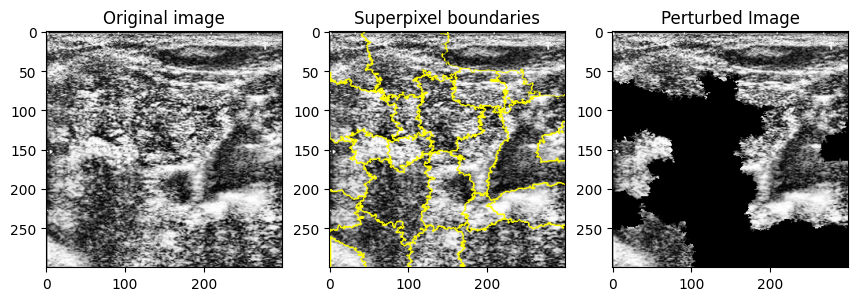

In [288]:
plt.figure(figsize=(14, 7))
plt.subplot(141)
plt.imshow(img)
plt.title('Original image')
plt.subplot(142)
LIME.plot_super_pixel_boundary()
plt.subplot(143)
LIME.plot_perturbed_image()
plt.show()

<class '__main__.LIME'>
(300, 300, 3)


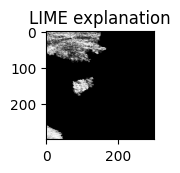

In [289]:
plt.subplot(144)
LIME.plot_explainable_image(explainable_model_type='decision_tree_regressor')
plt.show()